# Install Librairies

In [62]:
import tensorflow_addons as tfa

import tensorflow as tf
import os
from os import listdir
from os.path import isfile, join
import math
import cv2
import matplotlib.pyplot as plt
import matplotlib

from utils.conf import ROOT_DIR

# Configuration 

Check if gpu supported in this device

In [4]:
print(tf.__version__)

if tf.test.is_built_with_gpu_support():
    print("GPU is Supported")
else:
    print("GPU is not supported, check your configuration")

2.5.0
GPU is Supported


In [5]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [7]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [122]:
src_data = ROOT_DIR+"\\SOCOFing"
real_filenames = [f for f in listdir(join(src_data, "Real"))
                  if isfile(join(src_data, "Real", f))]
digit_count = math.ceil(math.log10(len(real_filenames) + 1))

easy_filenames = [f for f in listdir(join(src_data, "Altered", "Altered-Easy"))
                  if isfile(join(src_data, "Altered", "Altered-Easy", f))]
medium_filenames = [f for f in listdir(join(src_data, "Altered", "Altered-Medium"))
                    if isfile(join(src_data, "Altered", "Altered-Medium", f))]
hard_filenames = [f for f in listdir(join(src_data, "Altered", "Altered-Hard"))
                  if isfile(join(src_data, "Altered", "Altered-Hard", f))]

num_images = len(real_filenames)
print("The very listed filename: {}".format(real_filenames[0]))

The very listed filename: 100__M_Left_index_finger.BMP


In [126]:
medium_filenames[0]

'100__M_Left_index_finger_CR.BMP'

In [35]:
import imageio
import random

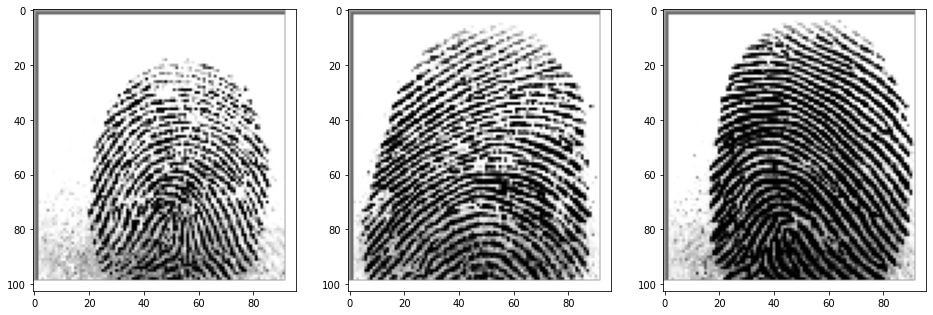

In [199]:
random.seed(42)
src_data = ROOT_DIR+"\\SOCOFing"
real_filenames = [src_data+"\\Real\\"+ f for f in listdir(join(src_data, "Real"))
                  if isfile(join(src_data, "Real", f))]
r = random.randint(5,num_images)
display_list = real_filenames[r:r+3]

image1 = imageio.imread(display_list[0])
image2 = imageio.imread(display_list[1])
image3 = imageio.imread(display_list[2])

fig, axes = plt.subplots(1,3,figsize = (16,16))
axes[0].imshow(image1)
axes[1].imshow(image2)
axes[2].imshow(image3)

# Preprocessing 

In [123]:
from collections import defaultdict
import cv2


# Each finger (regardless of who it blongs to or which finger it is) will have an entry
# in this dictionary. And each entry is a list while variations of the finger are entries
# of the list. Something like: {"1": ["/path_to_the_file/1__M_Left_index_finger.BMP", ...]}
# Basically, we are grouping all variations of the same fingerprint. One real
# and the rest altered
unique_sample = defaultdict(list)

for fn in real_filenames:
    unique_sample[fn[:fn.rindex(".")]] += [join(src_data, "Real", fn)]
for fn in easy_filenames:
    unique_sample[fn[:fn.rindex("_")]] += [join(src_data, "Altered", "Altered-Easy", fn)]
for fn in medium_filenames:
    unique_sample[fn[:fn.rindex("_")]] += [join(src_data, "Altered", "Altered-Medium", fn)]
for fn in hard_filenames:
    unique_sample[fn[:fn.rindex("_")]] += [join(src_data, "Altered", "Altered-Hard", fn)]

# There are some unwanted pixels around the input images, this function will get rid of them
def load_image(file_path):
    # Load the image grayscale
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    # Get rid of the excess pixels
    img = img[2:-4, 2:-4]
    # make sure all the images are of the same size (90 * 97)
    img = cv2.resize(img, (90, 97))
    return img

# The number of samples per each group
training_sample_count = 3000
validation_sample_count = 1500
test_sample_count = 1500

# "0000_00" -> "/.../Real/1__M_Left_index_finger.BMP"
id2path = {}
# "0000_00" -> Mat/np.array
dataset_images = {}
# "0000" -> ["00", "01", ...]
training_ids = defaultdict(list)
# "4000" -> ["00", "01", ...]
validation_ids = defaultdict(list)
# "5000" -> ["00", "01", ...]
test_ids = defaultdict(list)

for sample_id, sample in enumerate(unique_sample.items()):
    for variation_id, f in enumerate(sample[1]):
        # Polish and move the files into new folders. New filenames: {sample_id}_{variation}.png
        zero_padded_sample_id = str(sample_id).zfill(digit_count)
        zero_padded_variation_id = str(variation_id).zfill(2)
        new_id =  f"{zero_padded_sample_id}_{zero_padded_variation_id}"
        id2path[new_id] = f
        dataset_images[new_id] = load_image(f)

        # Have the ids in three separate dicitonaries: sample_id -> [variation_id]
        if sample_id < training_sample_count:
            training_ids[zero_padded_sample_id] += [zero_padded_variation_id]
        elif sample_id < training_sample_count + validation_sample_count:
            validation_ids[zero_padded_sample_id] += [zero_padded_variation_id]
        else:
            test_ids[zero_padded_sample_id] += [zero_padded_variation_id]

print("There are {} samples in the training dataset".format(sum([len(ids) for ids in training_ids.values()])))
print("There are {} samples in the validation dataset".format(sum([len(ids) for ids in validation_ids.values()])))
print("There are {} samples in the test dataset".format(sum([len(ids) for ids in test_ids.values()])))

There are 27576 samples in the training dataset
There are 13767 samples in the validation dataset
There are 13927 samples in the test dataset


In [152]:
import numpy as np
import random as rnd
import cv2


eps = np.finfo(np.float32).eps

def data_generator(images, dataset, batch_size, image_transformer=None, shuffle=True):
    """Generator function that yields batches of images

    Args:
        folder (string): The path to the folder holder images
        batch_size (int): Number of elements per batch.
        image_transformer (function, optional): If provided is applied to each image before using it
        shuffle (bool, optional): If the batches should be randomnized or not. Defaults to True.
    Yields:
        tuple: Of the form (input1, input2) with types (numpy.ndarray, numpy.ndarray)
        NOTE: input1: inputs to the model [img1a, img2a, img3a, ...]
              input2: targets to the model [img1b, img2b, img3b, ...] i.e. (img1a, img1b) belong to the same fingerprint
    """

    if len(dataset) < batch_size:
        print("Batch size set to " + str(len(dataset)) + " as that's the total number of records")
        batch_size = len(dataset)

    if shuffle:
        indices = rnd.sample(list(dataset.keys()), len(dataset))
    else:
        indices = list(dataset.keys())

    idx = 0
    input1 = []
    input2 = []

    while True:
        if idx >= len(indices):
            idx = 0
            if shuffle:
                indices = rnd.sample(list(dataset.keys()), len(dataset))
        variations = rnd.sample(dataset[indices[idx]], 2)
        id1 = indices[idx] + "_" + variations[0]
        id2 = indices[idx] + "_" + variations[1]
        input1.append(id1)
        input2.append(id2)
        idx += 1

        if len(input1) == batch_size:
            b1 = []
            b2 = []
            if image_transformer is not None:
                for f1, f2 in zip(input1, input2):
                    b1.append(image_transformer(images[f1]))
                    b2.append(image_transformer(images[f2]))
            else:
                for f1, f2 in zip(input1, input2):
                    b1.append(images[f1])
                    b2.append(images[f2])

            yield np.array(b1), np.array(b2)
            input1, input2 = [], []


def prepare_random_image(image, angle1=-45.0, angle2=45.0, scale1=.9, scale2=1.1, dx1=-10, dx2=10, dy1=-10, dy2=10):
    angle = rnd.uniform(angle1, angle2)
    scale = rnd.uniform(scale1, scale2)
    dx = rnd.randint(dx1, dx2)
    dy = rnd.randint(dy1, dy2)
    
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, scale)
    trnl_mat = np.float32([ [0, 0, dx], [0, 0, dy] ])
    trns_mat = trnl_mat + rot_mat
    result = cv2.warpAffine(image, trns_mat, image.shape[1::-1],
                            flags=cv2.INTER_LINEAR,
                            borderValue=(255, 255, 255))
    return np.expand_dims(result, axis=-1).astype(np.float32)

In [ ]:
prepare_random_image()

# Building our model 

In [229]:
import tensorflow.keras.backend as K

In [230]:
K.clear_session()

In [231]:
def normalize(x):
    return x / fastnp.sqrt(fastnp.sum(x * x, axis=-1, keepdims=True))

def our_model(d_model=128): 
    with strategy.scope():
        model = tf.keras.Sequential([
          tf.keras.layers.Conv2D(16, (3,3), padding='VALID', input_shape=(90,97,1)),
          tf.keras.layers.MaxPooling2D(2, padding='VALID'),
          tf.keras.layers.Conv2D(32, (3,3), padding='VALID'),
          tf.keras.layers.MaxPooling2D(2, padding='VALID'),
          tf.keras.layers.Conv2D(64, (3,3), padding='VALID'),
          tf.keras.layers.MaxPooling2D(2, padding='VALID'),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(d_model*2,activation='relu'),
          tf.keras.layers.Dense(d_model*3,activation='relu'),
          tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=-1))
        ])

        model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])
        return model

In [232]:
model = our_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 88, 95, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 44, 47, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 22, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 10, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 5760)              0

In [207]:
# Define the checkpoint directory to store the checkpoints

checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [208]:
def decay(epoch):
    if epoch < 3:
        return 1e-3
    elif epoch >= 3 and epoch < 7:
        return 1e-4
    else:
        return 1e-5

In [209]:
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))

In [210]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

## Training our Model

In [215]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, None, None, 16)    160       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, None, None, 16)    0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, None, None, 32)    4640      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, None, None, 32)    0         
_________________________________________________________________
flatten_15 (Flatten)         (None, None)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)               663808    
_________________________________________________________________
dense_32 (Dense)             (None, 384)             

In [212]:
batch_size = 768
train_generator = data_generator(dataset_images, training_ids, batch_size, image_transformer=prepare_random_image)
val_generator = data_generator(dataset_images, validation_ids, batch_size, image_transformer=prepare_random_image)

In [237]:
x,y = next(train_generator)
x.shape, y.shape

((768, 97, 90, 1), (768, 97, 90, 1))

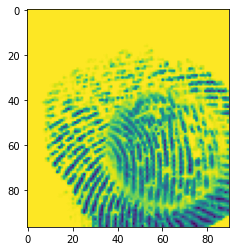

In [240]:
plt.imshow(x[0])

In [213]:
prepare_random_image(dataset_images['1226_02']).shape

(97, 90, 1)

In [233]:
model.fit(train_generator, epochs=12, callbacks=callbacks, steps_per_epoch=12000)

Epoch 1/12
INFO:tensorflow:Error reported to Coordinator: Shapes (None, None, None, None) and (None, 384) are incompatible
Traceback (most recent call last):
  File "c:\users\anass\my_ds\fingerprint_class\vfinger\lib\site-packages\tensorflow\python\training\coordinator.py", line 297, in stop_on_exception
    yield
  File "c:\users\anass\my_ds\fingerprint_class\vfinger\lib\site-packages\tensorflow\python\distribute\mirrored_run.py", line 334, in run
    self.main_result = self.main_fn(*self.main_args, **self.main_kwargs)
  File "c:\users\anass\my_ds\fingerprint_class\vfinger\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 692, in wrapper
    return converted_call(f, args, kwargs, options=options)
  File "c:\users\anass\my_ds\fingerprint_class\vfinger\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 382, in converted_call
    return _call_unconverted(f, args, kwargs, options)
  File "c:\users\anass\my_ds\fingerprint_class\vfinger\lib\site-packages\tensorf

ValueError: in user code:

    c:\users\anass\my_ds\fingerprint_class\vfinger\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    c:\users\anass\my_ds\fingerprint_class\vfinger\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\anass\my_ds\fingerprint_class\vfinger\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\anass\my_ds\fingerprint_class\vfinger\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\anass\my_ds\fingerprint_class\vfinger\lib\site-packages\tensorflow\python\distribute\mirrored_strategy.py:678 _call_for_each_replica
        return mirrored_run.call_for_each_replica(
    c:\users\anass\my_ds\fingerprint_class\vfinger\lib\site-packages\tensorflow\python\distribute\mirrored_run.py:104 call_for_each_replica
        return _call_for_each_replica(strategy, fn, args, kwargs)
    c:\users\anass\my_ds\fingerprint_class\vfinger\lib\site-packages\tensorflow\python\distribute\mirrored_run.py:245 _call_for_each_replica
        coord.join(threads)
    c:\users\anass\my_ds\fingerprint_class\vfinger\lib\site-packages\tensorflow\python\training\coordinator.py:389 join
        six.reraise(*self._exc_info_to_raise)
    c:\users\anass\my_ds\fingerprint_class\vfinger\lib\site-packages\six.py:703 reraise
        raise value
    c:\users\anass\my_ds\fingerprint_class\vfinger\lib\site-packages\tensorflow\python\training\coordinator.py:297 stop_on_exception
        yield
    c:\users\anass\my_ds\fingerprint_class\vfinger\lib\site-packages\tensorflow\python\distribute\mirrored_run.py:334 run
        self.main_result = self.main_fn(*self.main_args, **self.main_kwargs)
    c:\users\anass\my_ds\fingerprint_class\vfinger\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    c:\users\anass\my_ds\fingerprint_class\vfinger\lib\site-packages\tensorflow\python\keras\engine\training.py:796 train_step
        loss = self.compiled_loss(
    c:\users\anass\my_ds\fingerprint_class\vfinger\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    c:\users\anass\my_ds\fingerprint_class\vfinger\lib\site-packages\tensorflow\python\keras\losses.py:155 __call__
        losses = call_fn(y_true, y_pred)
    c:\users\anass\my_ds\fingerprint_class\vfinger\lib\site-packages\tensorflow\python\keras\losses.py:259 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    c:\users\anass\my_ds\fingerprint_class\vfinger\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    c:\users\anass\my_ds\fingerprint_class\vfinger\lib\site-packages\tensorflow\python\keras\losses.py:1643 categorical_crossentropy
        return backend.categorical_crossentropy(
    c:\users\anass\my_ds\fingerprint_class\vfinger\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    c:\users\anass\my_ds\fingerprint_class\vfinger\lib\site-packages\tensorflow\python\keras\backend.py:4862 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    c:\users\anass\my_ds\fingerprint_class\vfinger\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, None, None, None) and (None, 384) are incompatible
